In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as sps
import seaborn as sns
import scipy
import math

# Dataset
The data was taken from:

Mordaunt, C.E., Kieffer, D.A., Shibata, N.M. et al. Epigenomic signatures in liver and blood of Wilson disease patients include hypermethylation of liver-specific enhancers. Epigenetics & Chromatin 12, 10 (2019). https://doi.org/10.1186/s13072-019-0255-z

6 replicates for the first group - healthy controls (GEO ids: GSM3304382, GSM3304383, GSM3304384, GSM3304385, GSM3304386, GSM3304387)

6 replicates for the second group - Wilson disease (GEO ids: GSM3304393, GSM3304394, GSM3304395, GSM3304396, GSM3304397, GSM3304398)

In [2]:
methylation=pd.read_csv("meth.csv",sep=' ')
coverage=pd.read_csv("cov.csv",sep=' ')
pos = pd.read_csv("pos.csv",sep=' ')

In [3]:
positions = pos['chr']+":"+pos['pos'].astype(str)
methylation.index = positions
coverage.index = positions

Number of reads with methylated CpG at each position:

In [4]:
methylation

,H1,H2,H3,H4,H5,H6,W1,W2,W3,W4,W5,W6
chr1:100000277,1,1,0,0,0,0,0,0,1,0,0,0
chr1:100000313,0,0,1,0,0,0,0,1,1,0,0,0
chr1:100000438,1,0,0,0,0,0,1,0,0,0,0,0
chr1:1000007,0,0,0,0,0,0,0,0,0,0,0,0
chr1:1000009,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:9999706,1,0,0,0,0,0,0,0,0,0,0,0
chrY:9999805,0,0,1,0,0,0,1,0,1,0,0,0
chrY:9999846,0,0,2,0,1,0,1,0,2,0,0,0
chrY:9999866,1,0,1,0,1,0,1,0,2,0,0,0


Coverage for each CpG:

In [5]:
coverage

,H1,H2,H3,H4,H5,H6,W1,W2,W3,W4,W5,W6
chr1:100000277,1,1,0,0,0,0,0,1,1,0,0,0
chr1:100000313,0,0,1,0,0,0,0,1,1,0,0,0
chr1:100000438,1,0,0,0,0,0,1,0,0,0,0,0
chr1:1000007,4,1,2,1,5,6,2,3,4,6,3,1
chr1:1000009,4,2,2,1,5,6,2,3,4,6,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:9999706,1,0,0,0,0,0,1,0,0,0,0,1
chrY:9999805,0,0,1,0,0,0,1,0,2,0,0,0
chrY:9999846,1,0,2,0,1,0,1,0,4,0,0,0
chrY:9999866,1,0,1,0,1,0,1,0,3,0,0,0


Methylation ratio:

$𝑝_{ijk}=\frac{X_{ijk}}{𝑁_{ijk}}$

$X_{ijk}$ - the number of reads that show methylation

$𝑁_{ijk}$ - the total number of reads that cover this position

Methylation ratio for each position:

In [6]:
ratios=methylation/coverage

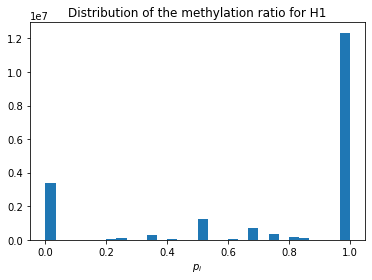

In [7]:
plt.hist(ratios['H1'].dropna(), bins=30)
plt.xlabel(r'$p_i$')
plt.title(r"Distribution of the methylation ratio for H1")
plt.show()

# Split data into 2 groups

In [8]:
group0_samples=['H1','H2','H3','H4','H5','H6']
group1_samples=['W1','W2','W3','W4','W5','W6']
group0_methylation=methylation[group0_samples]
group1_methylation=methylation[group1_samples]
group0_coverage=coverage[group0_samples]
group1_coverage=coverage[group1_samples]

Excluding sites with zero coverage for all replicates:

In [9]:
group0_nonzero_index = group0_coverage[(group0_coverage.T != 0).any()].index
group1_nonzero_index = group1_coverage[(group1_coverage.T != 0).any()].index
nonzero_index = group0_nonzero_index.intersection(group1_nonzero_index)
group0_methylation=group0_methylation.loc[nonzero_index,]
group1_methylation=group1_methylation.loc[nonzero_index,]
group0_coverage=group0_coverage.loc[nonzero_index,]
group1_coverage=group1_coverage.loc[nonzero_index,]

Calculating mean methylation level at each position for the first and the second group

In [10]:
group0_mean=group0_methylation.sum(axis = 1)/group0_coverage.sum(axis = 1)
group1_mean=group1_methylation.sum(axis = 1)/group1_coverage.sum(axis = 1)

# Beta-binomial-based approaches

$ X_{ijk}$  - the number of reads that corresponds to the methylated state of the CpG at i-th position, j-th group, k-th replicate

$ N_{ijk} $ - the total number of reads that covers this CpG

$ X_{ijk}|p_{ijk},N_{ijk} \sim Binomial(N_{ijk}, p_{ijk}) = {N_{ijk} \choose X_{ijk}}p_{ijk}^{ X_{ijk}}(1-p_{ijk})^{N_{ijk} - X_{ijk}} $

$ p_{ijk} \sim Beta(\alpha,\beta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}p_{ijk}^{\alpha-1}(1-p_i)^{\beta-1}	$

$ X_{ijk}|N_{ijk},\alpha,\beta \sim BetaBinomial(N_{ijk},\alpha,\beta) =\int_0^1{ Binomial(N_{ijk}, p_{ijk})Beta(\alpha,\beta)} dp_{ijk}$

Another type of parametrization:

$ X_{ijk}|N_{ijk},\mu,\theta \sim BetaBinomial(N_{ijk},\mu_{ij},\theta_{ij}) $, where

$\mu_{ij} = \frac{\alpha}{\alpha+\beta}$

$\theta_{ij} = \frac{1}{\alpha+\beta+1}$ - dispersion parameter


$E[X_{ijk}]=N_{ijk}\frac{\alpha}{\alpha+\beta}=N_{ijk}\mu_{ij}$ - Mean of the beta-binomial distribution

$Var[X_{ijk}]=\frac{N_{ijk}\alpha\beta(N_{ijk}+\alpha+\beta)}{(\alpha+\beta)^2(\alpha+\beta+1)}=N_{ijk}\mu_{ij}(1-\mu_{ij})(1+(N_{ijk}-1)\theta_{ij})$ - variance

See more at https://rpubs.com/cakapourani/beta-binomial

# DSS

It is a demonstration of the basic principles of DSS method:

Feng, H., Conneely, K. N., & Wu, H. (2014). A Bayesian hierarchical model to detect differentially methylated loci from single nucleotide resolution sequencing data. Nucleic acids research, 42(8), e69. https://doi.org/10.1093/nar/gku154

https://bioconductor.org/packages/release/bioc/html/DSS.html

We can detect the CpG site at current position as DML using Wald test:

$t_{i}=\frac{\mu_{i1}-\mu_{i2}}{\sqrt{var(\mu_{i1})-var(\mu_{i2})}}$

$H_{0}: \mu_{i1}=\mu_{i2}$

$H_{1}: \mu_{i1} \neq \mu_{i2}$

$\mu_{ij}$ - mean methylation ratio for j group, $\mu_{ij}=\frac{\sum_k{X_{ijk}}}{\sum_k{N_{ijk}}}$ (k replicates in a group)

$var(\mu_{ij})=var(\frac{\sum_k{X_{ijk}}}{\sum_k{N_{ijk}}})$ - variance of mean methylation ratio values for j group

It is assumed that methylation counts $X_{ijk}$ are independent:

$var(\mu_{ij}) = \frac{1}{\sum_k{N_{ijk}}^2}\sum_k{N_{ijk}\mu_{ij}(1-\mu_{ij})(1+(N_{ijk}-1)\theta_{ij})}$

$\theta_{ij}$ should be estimated

# Estimating dispersion parameter

What is the distribution of $\theta$ in our data?

$Var[X_{ijk}]=N_{ijk}\mu_{ij}(1-\mu_{ij})(1+(N_{ijk}-1)\theta_{ij})$ - variance

For Beta distribution:

$var(p_{ij}) = \frac{\alpha\beta}{(\alpha+\beta)^2(1+\alpha+\beta)}$


$var(p_{ij}) = \frac{\alpha\beta\theta_{ij}}{(\alpha+\beta)^2} =\mu_{ij}(1-\mu_{ij})\theta_{ij} $

$\theta_{ij} = \frac{var(p_{ij})}{\mu_{ij}(1-\mu_{ij})}$

We can use method of moments to estimate $\theta_{ij}$

Let's look at the distribution of $\theta_{ij}$ in our data (build a prior). We use sites with coverage > 10

In [11]:
cpgs_for_prior=coverage[coverage.mean(axis=1) > 10].index

In [12]:
def estimate_dispersion(methylation, coverage, group):
    prior_coverage = coverage.loc[cpgs_for_prior,]
    prior_methylation = methylation.loc[cpgs_for_prior,]
    p = (prior_methylation/prior_coverage)
    mm=p.mean(axis=1)
    vv = p.var(axis = 1)
    phi = vv/mm/(1-mm)
    lphi = np.log(phi[phi>0])
    plt.xlabel(r'$log(\theta_{ij})$')
    plt.title(r"prior distribution of $\theta_{ij}$ for group "+ group)
    plt.hist(lphi,bins=40)
    plt.show()
    prior_mean = np.median(lphi)
    prior_sd = sps.iqr(lphi, scale = 'normal')
    return prior_mean, prior_sd

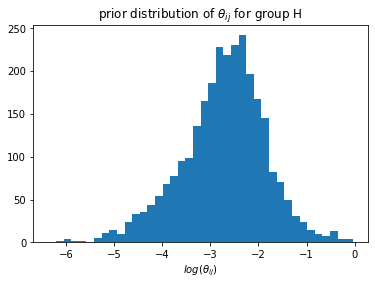

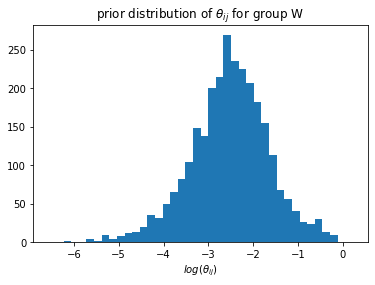

In [13]:
group0_prior_mean, group0_prior_sd = estimate_dispersion(group0_methylation, group0_coverage, 'H')
group1_prior_mean, group1_prior_sd = estimate_dispersion(group1_methylation, group1_coverage, 'W')

The distribution of $log(\theta_{ij})$ looks like normal distribution

$log(\theta_{ij}) \sim Normal(m_{j},r_{j}^2)$

If there is a small number of replicates, MOM estimates can be inaccurate. In this case we can borrow information from other CpG sites to increase statistical power - dispersion shrinkage

Empirical Bayes methods are procedures for statistical inference in which the prior distribution is estimated from the data.

We can get a point estimate for $\theta_{ij}$ maximizing this posterior likelihood.

Posterior distribution:

$P(\theta_{ij}|X_{ijk}) \sim L(X_{ijk}|\theta_{ij})P(\theta_{ij})$

Likelihood for the site i in group j:

$L(X_{ijk}|log(\theta_{ijk})) = \prod_k(BetaBinomial(N_{ijk},\mu_{ij},e^{log(\theta_{ij})}))$

Conditional posterior likelihood:

$L(log(\theta_{ijk})|X_{ijk}) = \prod_k{BetaBinomial(N_{ijk},\mu_{ij}, e^{log(\theta_{ij})})}*Normal(m_{ij},r_{ij}^2)$

Log likelihood:

$l(log(\theta_{ijk})|X_{ijk}) = \sum_k{log(BetaBinomial(N_{ijk},\mu_{ij}, e^{log(\theta_{ij})})})+log(Normal(m_{ij},r_{ij}^2)) $

Optimization for every single site is time consuming so I'll process only the first 5000 CpG sites

In [14]:
def posterior_likelihood(log_theta, X, N, mu, m, r):
    theta=scipy.special.expit(log_theta)
    alpha=mu*(1/theta-1)
    beta=1/theta-1-alpha
    return -(np.sum(sps.betabinom.logcdf(X.to_numpy(), N.to_numpy(), alpha, beta))+sps.norm.logpdf(theta,loc=m,scale=r))

In [15]:
pos_test=group0_methylation.iloc[:5000,].index
group0_methylation_test=group0_methylation.loc[pos_test,]
group0_coverage_test=group0_coverage.loc[pos_test,]
group0_mean_test=group0_mean.loc[pos_test,]
group1_methylation_test=group1_methylation.loc[pos_test,]
group1_coverage_test=group1_coverage.loc[pos_test,]
group1_mean_test=group1_mean.loc[pos_test,]

In [16]:
def get_max_likelihood_estimate(methylation,coverage,mean,prior_mean,prior_sd,group):
    theta=[]

    for pos in methylation.index:
        result=scipy.optimize.minimize(posterior_likelihood, x0=-5,
                                       args=(methylation.loc[pos,],
                                             coverage.loc[pos,],
                                             mean.loc[pos,],
                                             prior_mean,
                                             prior_sd,))
        theta.append(result.x[0])
    plt.xlabel(r'$log(\theta_{ij})$')
    plt.title(r"Max posterior likelihood estimates of $log(\theta_{ij})$ for group "+ group)
    plt.hist(theta,bins=50)
    plt.show()
    return scipy.special.expit(theta)

C:\Users\Anna\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:208: RuntimeWarning: overflow encountered in exp
  return exp(self._logpmf(x, n, a, b))


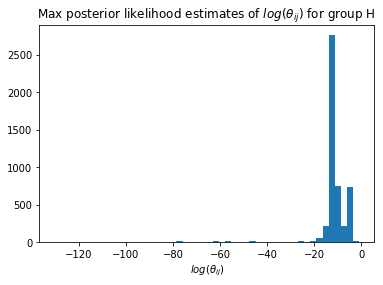

C:\Users\Anna\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:208: RuntimeWarning: overflow encountered in exp
  return exp(self._logpmf(x, n, a, b))
C:\Users\Anna\anaconda3\lib\site-packages\scipy\optimize\optimize.py:697: RuntimeWarning: invalid value encountered in subtract
  df = (f(*((xk + d,) + args)) - f0) / d[k]


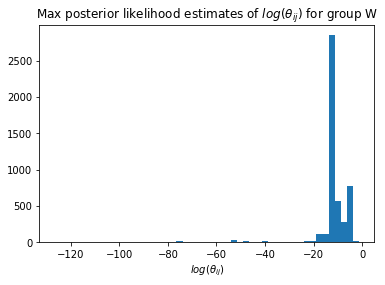

In [17]:
group0_theta_test = get_max_likelihood_estimate(group0_methylation_test,
                                               group0_coverage_test,
                                               group0_mean_test,
                                               group0_prior_mean,
                                               group0_prior_sd,
                                               'H')

group1_theta_test = get_max_likelihood_estimate(group1_methylation_test,
                                               group1_coverage_test,
                                               group1_mean_test,
                                               group1_prior_mean,
                                               group1_prior_sd,
                                               'W')

Now we can calculate variance using point estimates:

$var(\mu_{ij}) = \frac{1}{(\sum_k{N_{ijk}})^2}\sum_k{N_{ijk}\mu_{ij}(1-\mu_{ij})(1+(N_{ijk}-1)\theta_{ij})}$


In [18]:
def Wald_test():
    # convert mean and theta vectors to data frames
    group0_mean_df=pd.concat([group0_mean_test]*6,axis=1)
    group1_mean_df=pd.concat([group1_mean_test]*6,axis=1)
    group0_mean_df.columns,group1_mean_df.columns=group0_samples,group1_samples
    group0_theta_df=pd.concat([pd.Series(group0_theta_test,index = pos_test)]*6,axis=1)
    group1_theta_df=pd.concat([pd.Series(group1_theta_test,index = pos_test)]*6,axis=1)
    group0_theta_df.columns,group1_theta_df.columns=group0_samples,group1_samples
    
    # calculate variance
    group0_var_test = ((1/group0_coverage_test.sum(axis=1))**2)*(group0_coverage_test*group0_mean_df*(1-group0_mean_df)*(1+(group0_coverage_test-1)*group0_theta_df)).sum(axis=1)
    group1_var_test = ((1/group1_coverage_test.sum(axis=1))**2)*(group1_coverage_test*group1_mean_df*(1-group1_mean_df)*(1+(group1_coverage_test-1)*group1_theta_df)).sum(axis=1)
    var_test = group0_var_test+group1_var_test
    
    # bound it a little bit
    var_test[var_test < 1e-5] = 1e-4
    var_test[var_test > 1- 1e-5] = 1-1e-4
    
    # compute Wald stat
    t=(group0_mean_test-group1_mean_test)/np.sqrt(var_test)
    
    pvalue=2*sps.norm.cdf(-np.abs(t))
    return pvalue


In [19]:
pvalues = Wald_test()
result_df=pd.DataFrame({'pvalue':pvalues}, index = pos_test)

In [20]:
import statsmodels.stats.multitest as mt
fdr=mt.fdrcorrection(pvalues,alpha=0.05)
result_df['fdr']=fdr[1]

In [21]:
result_df[result_df['pvalue'] <= 0.05]

,pvalue,fdr
chr1:10000113,4.225688e-02,0.806784
chr1:100003347,0.000000e+00,0.000000
chr1:10001408,8.442616e-04,0.084426
chr1:100015152,0.000000e+00,0.000000
chr1:10002755,1.195412e-03,0.110686
...,...,...
chr1:100480621,4.328056e-08,0.000006
chr1:100485651,1.076597e-02,0.717731
chr1:100485921,0.000000e+00,0.000000
chr1:100491861,1.430591e-02,0.746070


DMLs after FDR correction:

In [22]:
result_df[result_df['fdr'] <= 0.05]

,pvalue,fdr
chr1:100003347,0.000000e+00,0.000000
chr1:100015152,0.000000e+00,0.000000
chr1:100047111,0.000000e+00,0.000000
chr1:100051696,0.000000e+00,0.000000
chr1:100059261,0.000000e+00,0.000000
chr1:100062054,0.000000e+00,0.000000
chr1:100069645,0.000000e+00,0.000000
chr1:10008685,0.000000e+00,0.000000
chr1:100098363,0.000000e+00,0.000000
chr1:100107932,0.000000e+00,0.000000


In [23]:
methylation.loc['chr1:100059261',]

H1    2
H2    0
H3    0
H4    0
H5    1
H6    1
W1    0
W2    0
W3    0
W4    0
W5    0
W6    0
Name: chr1:100059261, dtype: int64

In [24]:
coverage.loc['chr1:100059261',]

H1    2
H2    0
H3    0
H4    0
H5    1
H6    1
W1    1
W2    0
W3    0
W4    0
W5    0
W6    0
Name: chr1:100059261, dtype: int64